### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.plot import *

#### First example

In [2]:
## Create some sample data
data = np.random.rand(10, 3)

# Initialize a graph with default parameters
graph = Graph(data=data)

# Compute adjacency matrix
adjacency = graph.adjacency

# Compute normalized graph Laplacian
graph_laplacian = graph.graph_laplacian

print(f"{adjacency.shape=}")
print(f"{graph_laplacian.shape=}")

adjacency.shape=(10, 10)
graph_laplacian.shape=(10, 10)


#### Get some data

In [3]:
from sklearn import datasets
np.random.seed(42)


def affine_transform(data, apply_stretch=True, apply_shift=True):
    """
    Applies an affine transformation to input data.

    Parameters:
    - data (np.ndarray): Input data of shape (n_samples, 2).
    - apply_stretch (bool, optional): If True, applies a 2x stretch along y=x and a 0.8x stretch along y=-x.
    - apply_shift (bool, optional): If True, applies a shift of 0.25 along both x and y axes.

    Returns:
    - np.ndarray: Transformed data
    """
    new_data = data.copy()
    if apply_stretch:
        P = (1 / np.sqrt(2)) * np.array([[1, -1], [1, 1]])
        D = np.array([[2, 0], [0, 0.8]])
        M = P @ D @ P.T
        new_data = (M @ data.T).T
    if apply_shift:
        shift = np.array([0.25, 0.25])
        new_data += shift
    return new_data

Text(0, 0.5, '$u_2$')

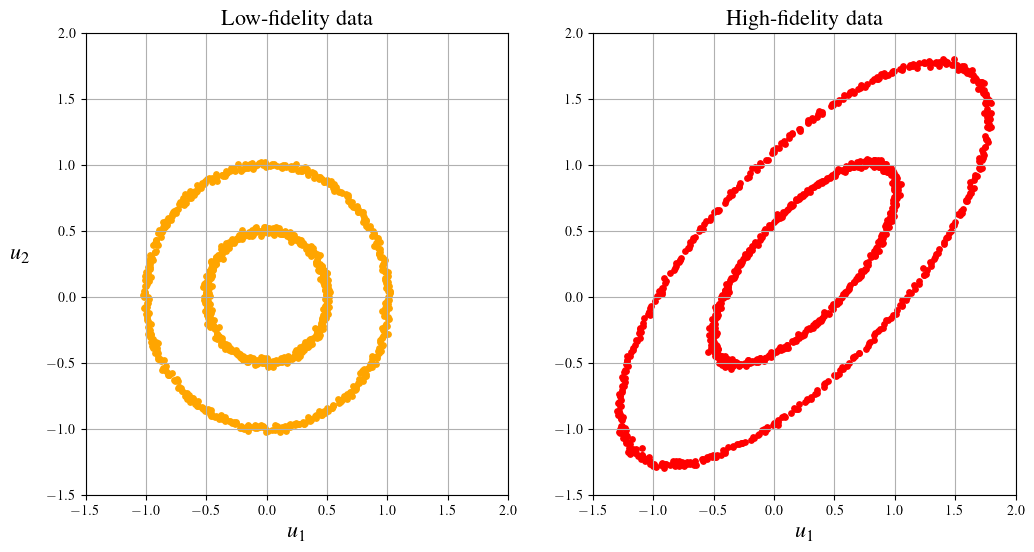

In [4]:
## Define low- and high-fidelity datasets

# Generate base data once without noise
n_samples = 1000
base_data, _ = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.,)

# Add different levels of noise to create low-fidelity and high-fidelity data
# An affine transformation is also applied to the high-fidelity data.
noise_scale_lf = 0.015
noise_scale_hf = 0.01
lf_noise = np.random.normal(scale=noise_scale_lf, size=base_data.shape)
hf_noise = np.random.normal(scale=noise_scale_hf, size=base_data.shape)

lf_data = base_data + lf_noise
hf_data = base_data + hf_noise
hf_data = affine_transform(hf_data)

# Plot the datasets
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title('Low-fidelity data', fontsize=16)
axs[0].scatter(lf_data[:, 0], lf_data[:, 1], s=15, c='orange')
axs[1].set_title('High-fidelity data', fontsize=16)
axs[1].scatter(hf_data[:, 0], hf_data[:, 1], s=15, c='red')

for ax in axs:
    ax.set_xlabel(r"$u_1$", fontsize=16)
    ax.grid(True)
    ax.set_xlim(-1.5, 2.)
    ax.set_ylim(-1.5, 2.)
    
axs[0].set_ylabel(r"$u_2$", fontsize=16, rotation=0, labelpad=20)

In [5]:
## Multi fidelity model

# Only a small set of high-fidelity data (10 points) is used to train the model. 
# The rest of the high-fidelity data is used for visual validation only.
n_lf = lf_data.shape[0]
n_hf = 10

hf_train_inds = np.random.choice(n_lf, n_hf)
hf_data_train = hf_data[hf_train_inds, :]

# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'method': 'full',
    'corr_scale': None,
    'k_adj': 11,
    'p': 0.5,
    'q': 0.5,
}

graph_lf = Graph(
    data=lf_data,
    **graph_config,
)

# Initialize the model
model_config = {
    'sigma': noise_scale_hf,
}
model = MultiFidelityModel(**model_config)

# Compute multi-fidelity data
mf_data, mf_covar_mat, mf_var = model.transform(
    graph_lf,
    hf_data_train,
    hf_train_inds,
)
model.summary()

Model Configuration:
sigma              : 0.01
beta               : 2
kappa              : 0.001
omega              : 608.5037816174225
method             : full
spectrum_cutoff    : None
tau                : 0.0012819419490994527


Text(0, 0.5, '$u_2$')

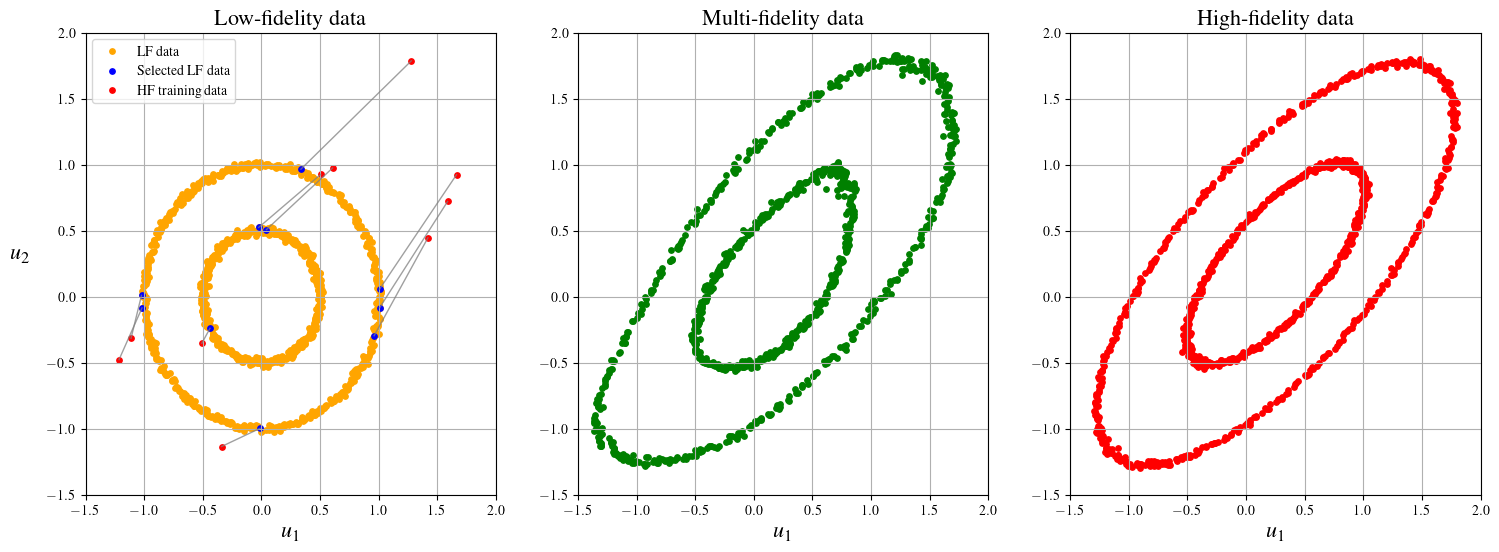

In [6]:
## Plot results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Low-fidelity data
axs[0].set_title("Low-fidelity data", fontsize=16)
axs[0].scatter(lf_data[:, 0], lf_data[:, 1], color='orange', s=15, label='LF data')
axs[0].scatter(lf_data[hf_train_inds, 0], lf_data[hf_train_inds, 1], s=15, color='blue', label='Selected LF data')
axs[0].scatter(hf_data_train[:, 0], hf_data_train[:, 1], color='red', s=15, label='HF training data')
axs[0].legend()
for i in range(len(hf_train_inds)):
    axs[0].plot(
        [lf_data[hf_train_inds[i], 0], hf_data_train[i, 0]],
        [lf_data[hf_train_inds[i], 1], hf_data_train[i, 1]],
        color='grey',
        linewidth=1.,
        alpha=0.75,
    )

# Multi-fidelity data
axs[1].set_title("Multi-fidelity data", fontsize=16)
axs[1].scatter(mf_data[:, 0], mf_data[:, 1], s=15, color='green')

# High-fidelity data
axs[2].set_title("High-fidelity data", fontsize=16)
axs[2].scatter(hf_data[:, 0], hf_data[:, 1], s=15, color='red')

for ax in axs:
    ax.set_xlabel(r"$u_1$", fontsize=16)
    ax.grid(True)
    ax.set_xlim(-1.5, 2.)
    ax.set_ylim(-1.5, 2.)
axs[0].set_ylabel(r"$u_2$", fontsize=16, rotation=0, labelpad=20)

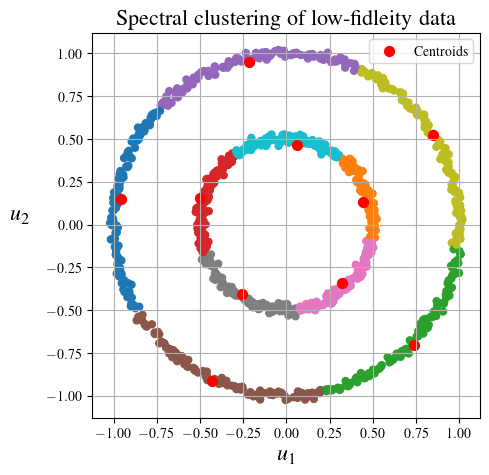

In [7]:
## Perform clustering on the graph to find the high-fidelity indices
inds_centroids, labels = graph_lf.cluster(n=n_hf)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Spectral clustering of low-fidleity data", fontsize=16)
ax.scatter(lf_data[:, 0], lf_data[:, 1], s=25, c=labels, cmap='tab10')
ax.scatter(lf_data[inds_centroids, 0], lf_data[inds_centroids, 1], color='red', s=50, label='Centroids')

ax.legend()
ax.set_xlabel(r"$u_1$", fontsize=16)
ax.set_ylabel(r"$u_2$", fontsize=16, rotation=0, labelpad=20)
ax.grid(True)

Model Configuration:
sigma              : 0.01
beta               : 2
kappa              : 0.0985083130435562
omega              : 59942.68100775682
method             : full
spectrum_cutoff    : None
tau                : 0.0012819419490994527


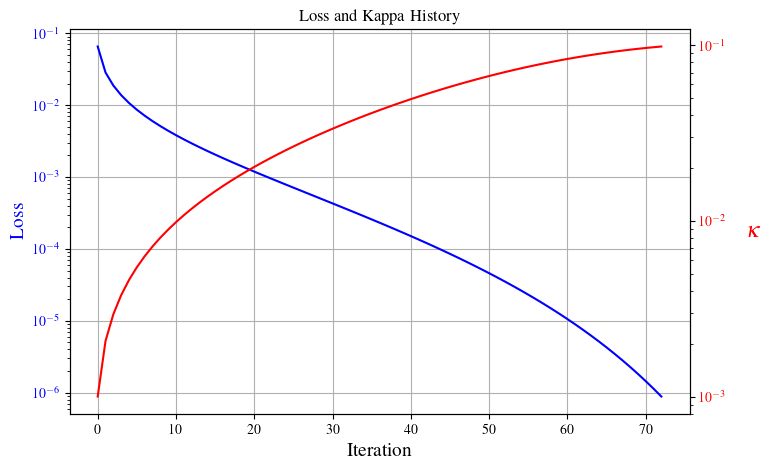

In [8]:
## Aquire high-fidelity data at the centroids location
hf_data_train = hf_data[inds_centroids, :]

## Initialize the model
model_config = {
    'sigma': noise_scale_hf,
}
model = MultiFidelityModel(**model_config)

## Fit and transform to get multi-fidelity data
# This will find the value of hyperparameter kappa that leads to given level of uncertainty 
# in the multi-fidelity estimates.
mf_data, mf_covar_mat, mf_var, loss_history, kappa_history = model.fit_transform(
    graph_lf,
    hf_data_train,
    inds_centroids,
    maxiter=200,
    step_size=10,
    step_decay_rate=1.05,
    ftol=1e-6,
    gtol=1e-8,
    verbose=False,
)

# Plot the model final configuration and loss history
model.summary()
plot_loss_and_kappa(loss_history, kappa_history)

Text(0, 0.5, '$u_2$')

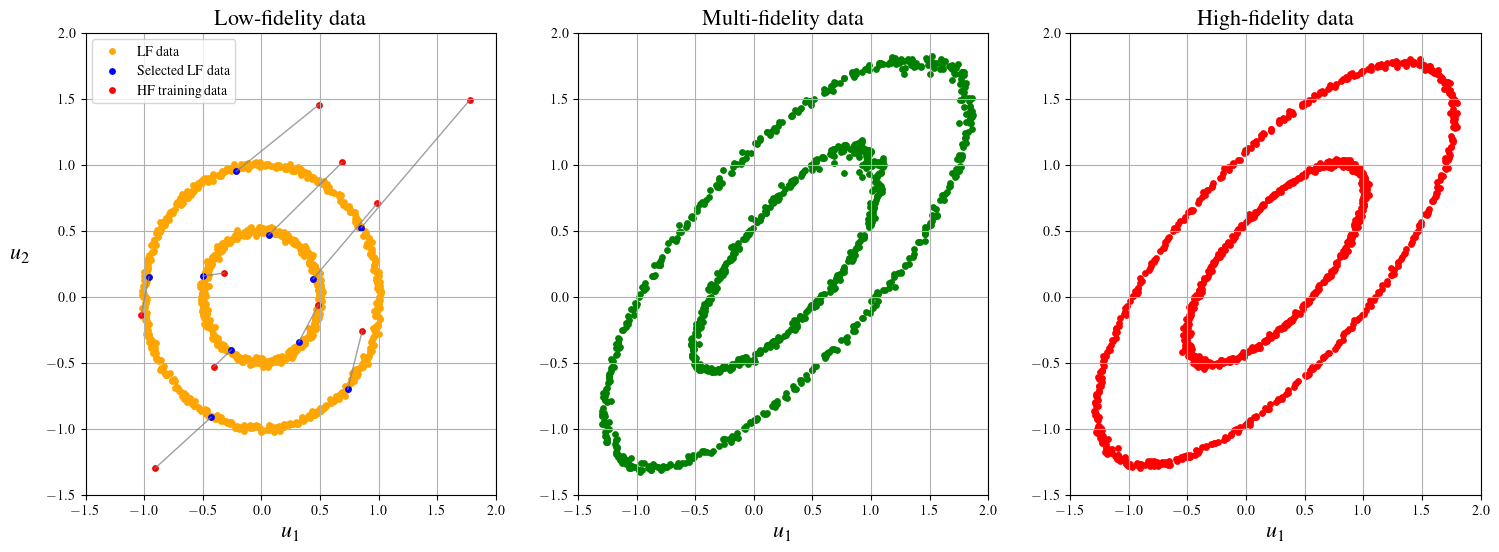

In [9]:
## Plot results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Low-fidelity data
axs[0].set_title("Low-fidelity data", fontsize=16)
axs[0].scatter(lf_data[:, 0], lf_data[:, 1], color='orange', s=15, label='LF data')
axs[0].scatter(lf_data[inds_centroids, 0], lf_data[inds_centroids, 1], s=15, color='blue', label='Selected LF data')
axs[0].scatter(hf_data_train[:, 0], hf_data_train[:, 1], color='red', s=15, label='HF training data')
axs[0].legend()
for i in range(len(inds_centroids)):
    axs[0].plot(
        [lf_data[inds_centroids[i], 0], hf_data_train[i, 0]],
        [lf_data[inds_centroids[i], 1], hf_data_train[i, 1]],
        color='grey',
        linewidth=1.,
        alpha=0.75,
    )

# Multi-fidelity data
axs[1].set_title("Multi-fidelity data", fontsize=16)
axs[1].scatter(mf_data[:, 0], mf_data[:, 1], s=15, color='green')

# High-fidelity data
axs[2].set_title("High-fidelity data", fontsize=16)
axs[2].scatter(hf_data[:, 0], hf_data[:, 1], s=15, color='red')

for ax in axs:
    ax.set_xlabel(r"$u_1$", fontsize=16)
    ax.grid(True)
    ax.set_xlim(-1.5, 2.)
    ax.set_ylim(-1.5, 2.)
axs[0].set_ylabel(r"$u_2$", fontsize=16, rotation=0, labelpad=20)

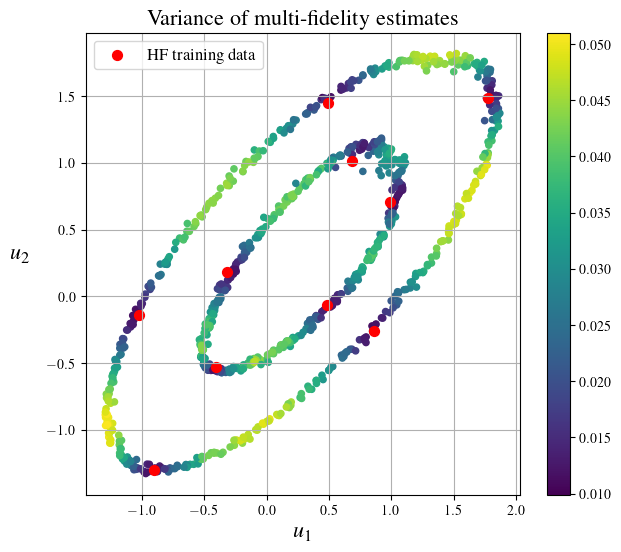

In [10]:
## Plot the variance of multi-fidelity esimates
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
scatter = ax.scatter(mf_data[:, 0], mf_data[:, 1], c=mf_var, s=20,)
ax.scatter(mf_data[inds_centroids, 0], mf_data[inds_centroids, 1], c='red', s=50, label='HF training data')
ax.set_title("Variance of multi-fidelity estimates", fontsize=16)
ax.set_xlabel(r"$u_1$", fontsize=16)
ax.set_ylabel(r"$u_2$", fontsize=16, rotation=0, labelpad=20)
fig.colorbar(scatter, ax=ax,)
ax.legend(loc="upper left", fontsize=12)
ax.grid(True)